## Mechanical Contact

We want to compute the displacement of a flat surface applied distributed pressure. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import time

First we define our test pressure as:

$$
p(x, y)=\cos \left(\frac{2 \pi x}{L}\right) \cos \left(\frac{2 \pi y}{L}\right)
$$

In [2]:
def pressure_distribution(x, y, x0, y0, L, p0):
    return p0 * np.cos(2*np.pi*(x-x0)/L) * np.cos(2*np.pi*(y-y0)/L)

L = 1.0
#a = 1.0
#b = 1.0
p0 = 1.0
x0 = 0
y0 = 0


In [3]:
#We generate a 2D coordinate space
n = 100
m = 100

x, y = np.meshgrid(np.linspace(0, L, n, endpoint=False), np.linspace(0, L, m, endpoint=False))#notice here that we use endpoint=False to avoid having the last point

In [4]:
#We calculate test pressure on the grid
test_pressure = pressure_distribution(x, y, x0, y0, L, p0)
#test_pressure

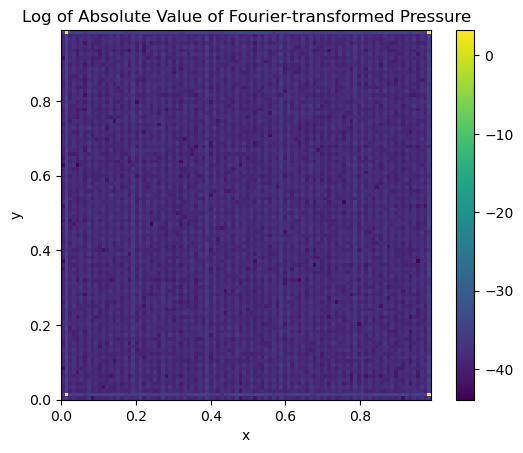

In [5]:
#We generate the pressure distribution in Fourier space
pressure_fourier = np.fft.fft2(test_pressure, norm='ortho')

'''
#We want to visualize the pressure in Fourier space
fig, ax = plt.subplots()
ax.plot(x, pressure_fourrier, linewidth=2.0)
plt.show()

'''


# Visualization of the Fourier-transformed pressure
fig, ax = plt.subplots()
extent = [x.min(), x.max(), y.min(), y.max()]
im = ax.imshow(np.log(np.abs(pressure_fourier)), extent=extent, origin='lower')#not so clear with abs here # That means we take the norm of the complex number
plt.colorbar(im, ax=ax)
plt.title('Log of Absolute Value of Fourier-transformed Pressure')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We also need to define our Kernel function in fourrier domain:

$$
\mathcal{F}(f)=\frac{2}{E^* \sqrt{q_x^2+q_y^2}}
$$




In [6]:
#material parameters
E = 2.1e2
nu = 0.3

In [7]:
#We generate Kernel function/Green function/fundamental solution

E_star = E/(1-nu**2)

#we define the frequency with q_x and q_y
q_x = 2 * np.pi * np.fft.fftfreq(n, d=L/n)
q_y = 2 * np.pi * np.fft.fftfreq(m, d=L/m)
QX, QY = np.meshgrid(q_x, q_y)

kernel_fourier = np.zeros_like(QX)  # Initialize the kernel array
#non_zero_indices = (QX**2 + QY**2) != 0  # Avoid division by zero
kernel_fourier = 2 / (E_star * np.sqrt(QX**2 + QY**2))
kernel_fourier[0, 0] = 0  # Set the zero frequency component to zero

#print(type(kernel_fourier))


<class 'numpy.ndarray'>


/var/folders/8h/9pns8j3d2sl62pk5rmmfs01h0000gn/T/ipykernel_28319/2263871874.py:11: RuntimeWarning: divide by zero encountered in divide
  kernel_fourier = 2 / (E_star * np.sqrt(QX**2 + QY**2))


### Question1: 
For **np.fft.fftfreq(N, d=a/N)**, we define **d** only with **L**, what will happen if the contact region is not symmetric (from [-a,a] or [-a,b])

$$
\mathcal{F}(u)= \mathcal{F}(f) \bullet \mathcal{F}(p) 
$$

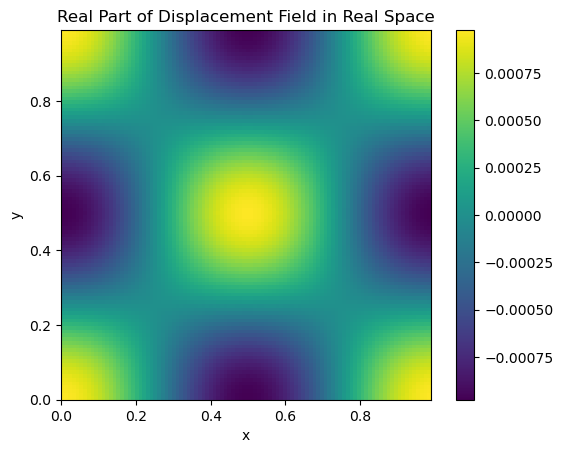

In [8]:
#Calculate the displacement field in fourrier space
displacement_fourrier = pressure_fourier * kernel_fourier

#We calculate the displacement field in real space
displacement_real = np.fft.ifft2(displacement_fourrier, norm='ortho')


# Since displacement_analytical is a large array, we won't print it directly to avoid clutter.
# Instead, let's visualize the real part of the displacement in real space for comparison.
plt.figure()
plt.imshow(np.real(displacement_real), extent=extent, origin='lower')
plt.colorbar()
plt.title('Real Part of Displacement Field in Real Space')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Then we define analytical solution as follow:

$$
u(x, y)=\frac{1}{E^* \pi \sqrt{2}} \cos \left(\frac{2 \pi x}{L}\right) \cos \left(\frac{2 \pi y}{L}\right)
$$


In [9]:
def analytical_solution(x, y, x0, y0, L, E, nu):
    E_star = E / (1 - nu**2)
    return np.cos(2*np.pi*(x-x0)/L)*np.cos(2*np.pi*(y-y0)/L) / (np.sqrt(2)*np.pi*E_star)


#displacement_analytical = analytical_solution(x, y, x0, y0, L, E, nu)
start_time_analytical = time.process_time()
displacement_analytical = analytical_solution(x, y, x0, y0, L, E, nu)
end_time_analytical = time.process_time()

cpu_time_analytical = end_time_analytical - start_time_analytical
print("CPU time for calling analytical_solution:", cpu_time_analytical, "seconds")


print(displacement_analytical)

CPU time for calling analytical_solution: 0.0048520000000000785 seconds
[[0.00097534 0.00097342 0.00096765 ... 0.00095807 0.00096765 0.00097342]
 [0.00097342 0.0009715  0.00096574 ... 0.00095618 0.00096574 0.0009715 ]
 [0.00096765 0.00096574 0.00096002 ... 0.00095051 0.00096002 0.00096574]
 ...
 [0.00095807 0.00095618 0.00095051 ... 0.0009411  0.00095051 0.00095618]
 [0.00096765 0.00096574 0.00096002 ... 0.00095051 0.00096002 0.00096574]
 [0.00097342 0.0009715  0.00096574 ... 0.00095618 0.00096574 0.0009715 ]]


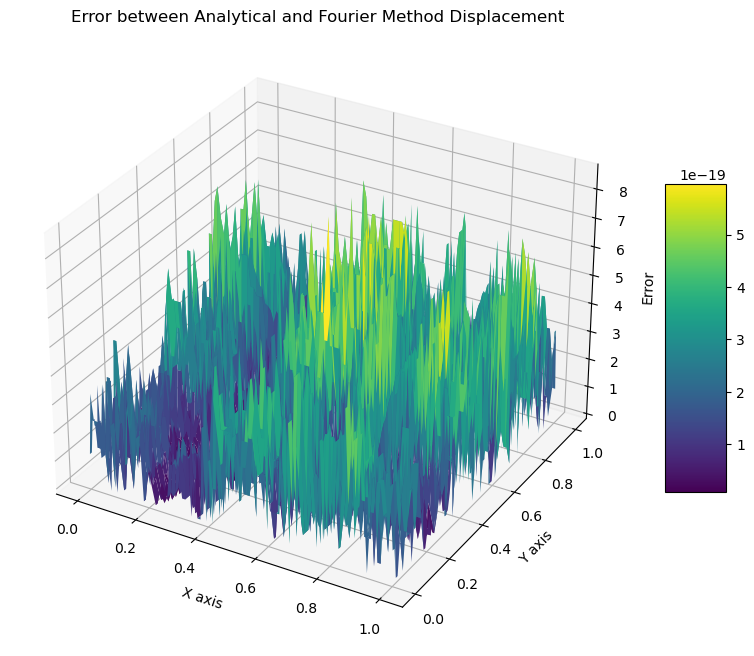

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Calculate the error between the real part of the displacement obtained through FFT and the analytical solution
error = np.abs(np.real(displacement_real) - displacement_analytical)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a surface plot of the error
X, Y = np.meshgrid(np.linspace(0, L, n), np.linspace(0, L, m))
surf = ax.plot_surface(X, Y, error, cmap='viridis', edgecolor='none')

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Error')
ax.set_title('Error between Analytical and Fourier Method Displacement')

plt.show()